In [1]:
import sys
sys.path.append('../../../GraphGallery/')
sys.path.append('../../../GraphAdv/')

from graphgallery.nn.models import GCN
from graphadv.attack.untargeted import PGD


import matplotlib.pyplot as plt

In [2]:
from graphgallery.data import NPZDataset
data = NPZDataset('citeseer', root="~/GraphData/datasets/", verbose=False, standardize=True)
adj, x, labels = data.graph.unpack()
idx_train, idx_val, idx_test = data.split(random_state=15)


Downloaded dataset files have existed.
Processing...
Processing completed.


In [3]:
attacker = PGD(adj, x, labels, idx_train, device="GPU", seed=None, surrogate_args={'idx_val':idx_val})
attacker.reset()
attacker.attack(0.25, structure_attack=True, feature_attack=False)
# show logs
attacker.show_edge_flips(detail=False)

=== PGD: Train a surrogate model `DenseGCN` from scratch ===


Random Sampling: 100%|██████████| 20/20 [00:00<00:00, 229.13it/s]

Flip 912 edges, 908 added, 4 removed. Added edges with different classes: 94.49%, removed edges with the same classes: 75.00%


# Before Attack

In [4]:
model_before = GCN(adj, x, labels, device='GPU', norm_x=None, seed=42)
model_before.build()
his_before = model_before.train(idx_train, verbose=1, epochs=100)
loss, accuracy = model_before.test(idx_test)
print(f'Test loss {loss:.5}, Test accuracy {accuracy:.2%}')

<Loss = 0.1372 Acc = 0.9953 >: 100%|██████████| 100/100 [00:00<00:00, 136.04it/s]


Test loss 1.321, Test accuracy 71.09%


# After Attack

In [5]:
model_after = GCN(attacker.A, x, labels, device='GPU', norm_x=None, seed=42)
model_after.build()
his_after = model_after.train(idx_train, verbose=1, epochs=100)
loss, accuracy = model_after.test(idx_test)
print(f'Test loss {loss:.5}, Test accuracy {accuracy:.2%}')

<Loss = 0.3127 Acc = 0.9763 >: 100%|██████████| 100/100 [00:00<00:00, 147.67it/s]


Test loss 1.6089, Test accuracy 55.63%


#  Visulation

In [6]:
def plot(his_before, his_after, metric="loss"):
    with plt.style.context(['science', 'no-latex']):
        plt.plot(his_before.history[metric])
        plt.plot(his_after.history[metric])
        plt.legend([f'{metric.title()} Before', f'{metric.title()} After'])
        plt.ylabel(f'{metric.title()}')
        plt.xlabel('Epochs')
        plt.show()    

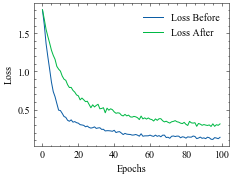

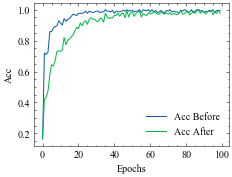

In [7]:
plot(his_before, his_after, metric="loss")
plot(his_before, his_after, metric="acc")